# Importing Libraries and Datasets

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from sklearn import linear_model, feature_selection, metrics, model_selection, datasets
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
import pypalettes
import warnings
warnings.filterwarnings('ignore')

counties_pol_party = pd.read_csv('counties_pol.csv')

In [107]:
import seaborn.objects as so

In [4]:
counties_pol_party.shape
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

In [6]:
# changing fips to str value
counties_pol_party['fips']= counties_pol_party['fips'].astype(str)

## Standardizing Values

In [7]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
counties_pol_copy = counties_pol_party.copy()

In [8]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [9]:
z_counties= calc_z(counties_pol_copy, vars_to_z)

# Variable Selection with Pairwise Mutual Information 

In [10]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_party[[var1]]
        y = counties_pol_party[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.105872               0.076216   
gender_pay_gap                        0.044257               0.005853   
school_segration_index                0.025045               0.041725   
residential_segregation               0.044906               0.002189   
school_funding_gap                    0.221971               0.037437   

                         population  median_income  uninsured__percentage  \
income_inequality          0.025975       0.210192               0.071778   
gender_pay_gap             0.072664       0.022339               0.035208   
school_segration_index     0.179259       0.025225               0.007981   
residential_segregation    0.080776       0.021691               0.072779   
school_funding_gap         0.088499       0.249663               0.247439   

                         premature_death  child_poverty_percentage  \
income_inequality           

## Visualizing Pairwise Mutual Information as Heatmap

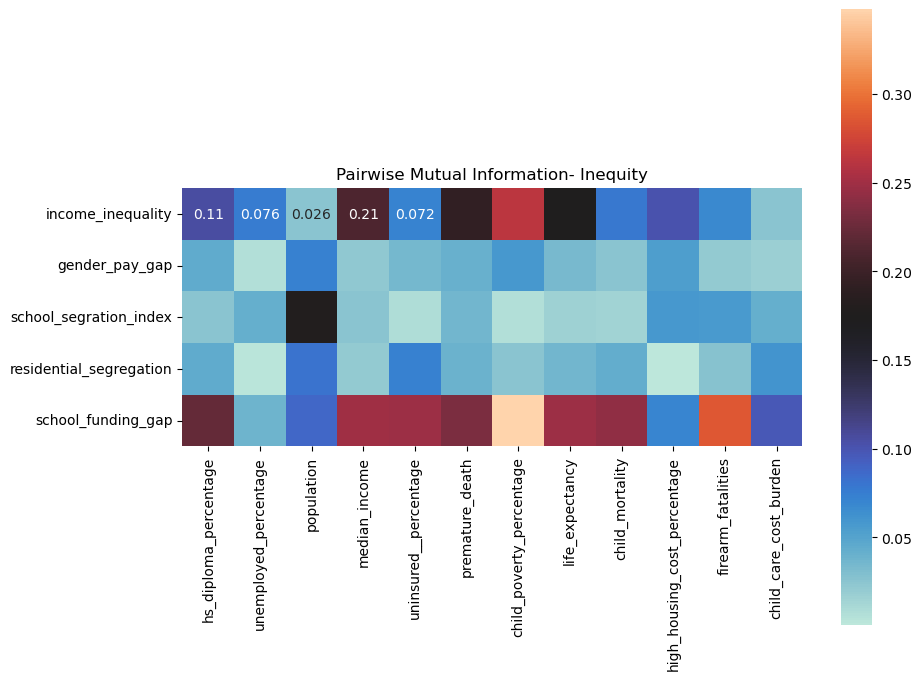

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='icefire', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

# Identifying most 'informative' pairs

In [12]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap        0.347860
firearm_fatalities        school_funding_gap        0.286257
child_poverty_percentage  income_inequality         0.262992
median_income             school_funding_gap        0.249663
life_expectancy           school_funding_gap        0.248601
uninsured__percentage     school_funding_gap        0.247439
child_mortality           school_funding_gap        0.242546
premature_death           school_funding_gap        0.232733
hs_diploma_percentage     school_funding_gap        0.221971
median_income             income_inequality         0.210192
premature_death           income_inequality         0.192038
population                school_segration_index    0.179259
dtype: float64


### Selecting most 'informative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

*including political party elected from 2020 general election for additional comparative visualizations*

In [13]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_party[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality']
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

# Descriptive Statistics for Selected Variables

In [14]:
agg_select_subset.describe().round(2)

school_funding_gap  child_poverty_percentage  income_inequality  \
count             1648.00                   1648.00            1648.00   
mean              -804.97                      0.19               4.60   
std               6428.72                      0.08               0.71   
min             -46776.99                      0.03               2.88   
25%              -3452.36                      0.13               4.10   
50%               -309.82                      0.18               4.49   
75%               2283.42                      0.23               4.98   
max              21187.84                      0.54               8.28   

       firearm_fatalities  median_income  life_expectancy  premature_death  
count             1648.00        1648.00          1648.00          1648.00  
mean                16.77       67337.94            74.85         10482.46  
std                  7.60       16490.49             3.22          3315.20  
min                  1.86       34176.00            63.84          3990.29  
25%                 11.69       55568.00            72.60          8089.24  
50%                 15.87       64090.50            74.88         10155.80  
75%                 20.47       75447.00            77.07         12482.99  
max                 79.46      144807.00            89.67         27851.41

In [15]:
sns.set_theme(style='whitegrid', palette='icefire')

def plot_histograms_boxplots(data, columns):
    fig, axes = plt.subplots(len(columns), 2, figsize=(12, 4 * len(columns)))
    for i, col in enumerate(columns):
        # Histogram
        sns.histplot(data[col], kde=True, color='#2D83A6', ax=axes[i, 0])
        axes[i, 0].set_title(f'Histogram of {col}')
        # Boxplot
        sns.boxplot(x=data[col], color='#F24738', ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {col}')
    plt.tight_layout()

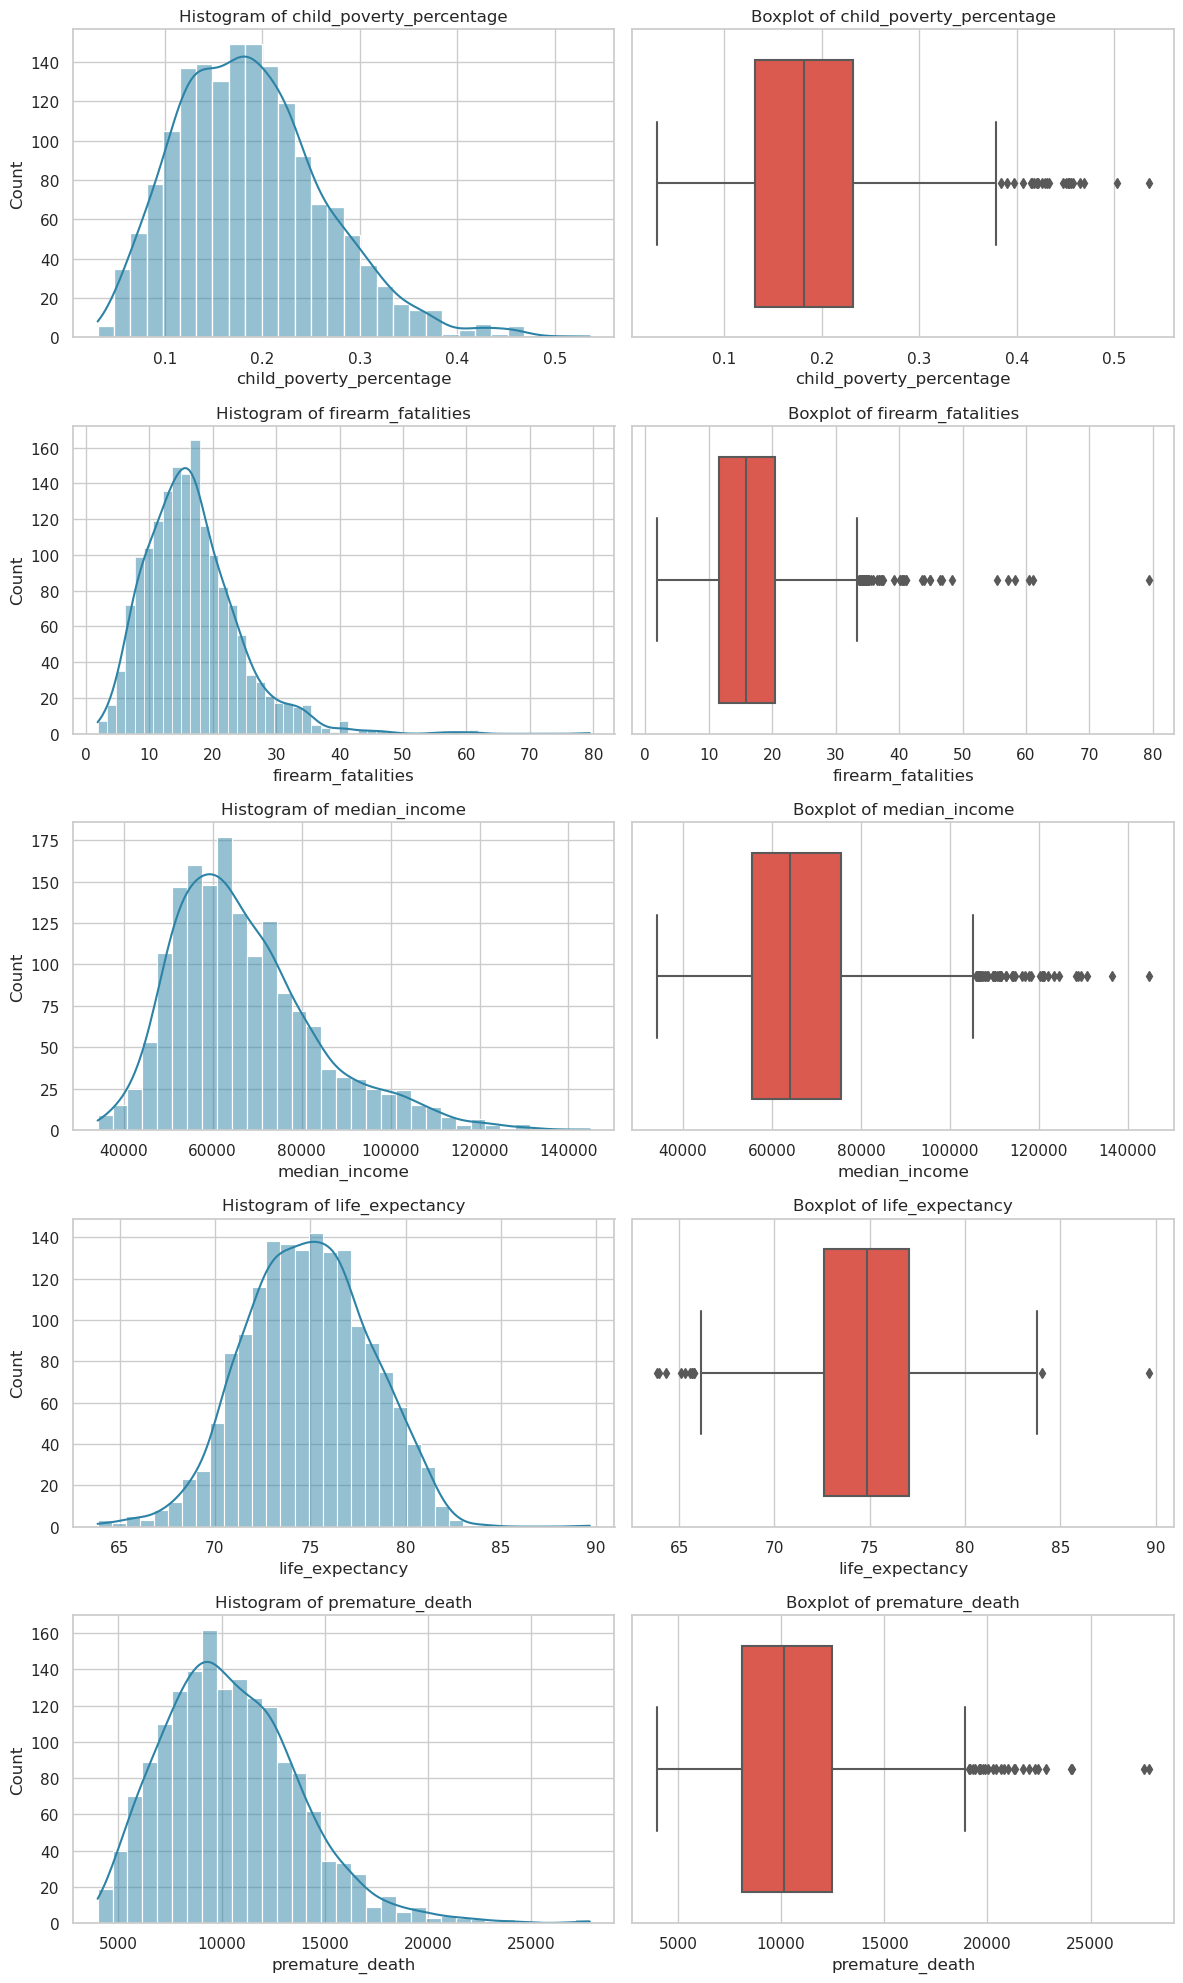

In [16]:
plot_histograms_boxplots(agg_select_subset, y_vars)

## Variance 

In [17]:
agg_select_subset.var(numeric_only=True)

school_funding_gap          4.132847e+07
child_poverty_percentage    5.870140e-03
income_inequality           5.075141e-01
firearm_fatalities          5.772999e+01
median_income               2.719364e+08
life_expectancy             1.040037e+01
premature_death             1.099053e+07
dtype: float64

## Correlation 

<Axes: >

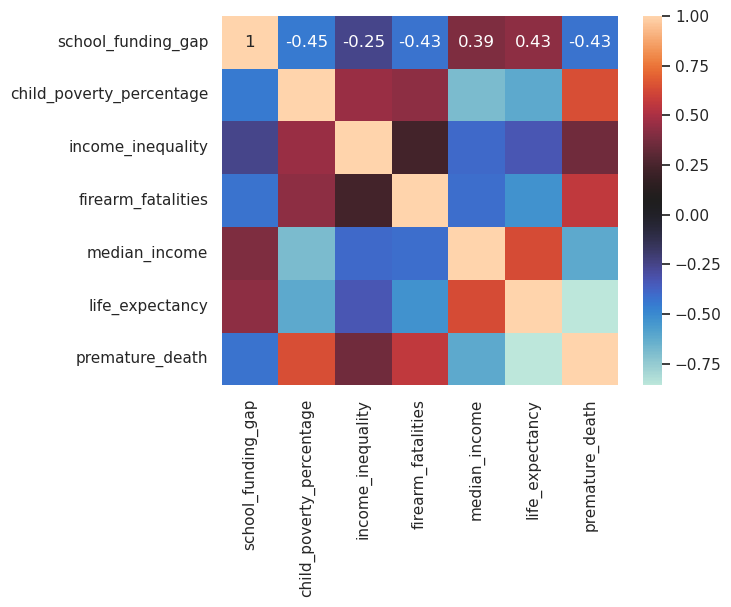

In [18]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='icefire')

### Correlation Pairs

In [19]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

child_poverty_percentage   -0.637112
firearm_fatalities         -0.604100
median_income               0.496392
life_expectancy             0.564720
premature_death            -0.579993
dtype: float64


In [20]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

child_poverty_percentage    0.622599
firearm_fatalities          0.366110
median_income              -0.503023
life_expectancy            -0.458570
premature_death             0.512731
dtype: float64


### Covariance

In [21]:
agg_select_subset.cov(numeric_only=True).round(2)

school_funding_gap  child_poverty_percentage  \
school_funding_gap               41328467.77                   -313.81   
child_poverty_percentage             -313.81                      0.01   
income_inequality                   -1604.99                      0.03   
firearm_fatalities                 -29507.62                      0.36   
median_income                    52623929.12                  -1025.68   
life_expectancy                     11707.99                     -0.19   
premature_death                 -12361094.39                    206.09   

                          income_inequality  firearm_fatalities  \
school_funding_gap                 -1604.99           -29507.62   
child_poverty_percentage               0.03                0.36   
income_inequality                      0.51                1.98   
firearm_fatalities                     1.98               57.73   
median_income                      -5909.43           -67516.43   
life_expectancy                       -1.05              -16.64   
premature_death                     1210.94            18173.46   

                          median_income  life_expectancy  premature_death  
school_funding_gap         5.262393e+07         11707.99     -12361094.39  
child_poverty_percentage  -1.025680e+03            -0.19           206.09  
income_inequality         -5.909430e+03            -1.05          1210.94  
firearm_fatalities        -6.751643e+04           -16.64         18173.46  
median_income              2.719364e+08         41980.70     -41437689.02  
life_expectancy            4.198070e+04            10.40        -10274.20  
premature_death           -4.143769e+07        -10274.20      10990534.91

## Pair Plots

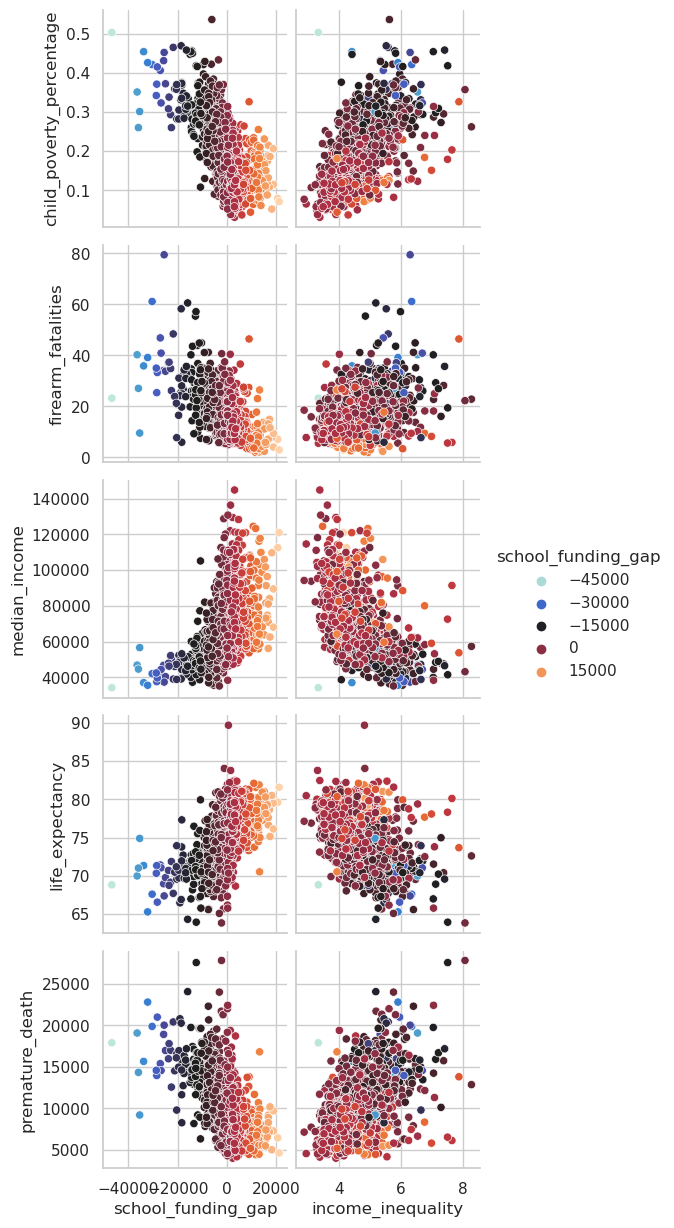

In [22]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    hue = 'school_funding_gap',
    palette='icefire',
    )     

# Regression

focusing on highest correlation pairs:
### school_funding
- child_poverty_percentage
- firearm_fatalities
- life_expectancy 

### income_inequality 
- child_poverty_percentage
- median_income
- premature_death

In [23]:
X_1 = agg_select_subset['school_funding_gap']
X_2 = agg_select_subset['income_inequality']
y_1 = agg_select_subset['child_poverty_percentage']
y_2 = agg_select_subset['firearm_fatalities']
y_3 = agg_select_subset['median_income']
y_4 = agg_select_subset['life_expectancy']
y_5 = agg_select_subset['premature_death']


## Linear Regression


Define function for plotting pairs of interest individually

In [24]:
line_color2 = '#BF1717'
line_color_1='#2D83A6'

In [25]:
def poly_reg_line(x_val, y_val, slope_val, intercept_val):
    sns.scatterplot(x = x_val, y = y_val, hue = x_val, palette ='icefire') 
    slope_val, intercept_val = np.polyfit(x_val, y_val, 1)
    plt.plot(x_val, slope_val*x_val + intercept_val, color= '#BF1717', label='Regression Line')

### Plotting School Funding 

#### Child Poverty

In [26]:
model_1= smf.ols(formula='child_poverty_percentage ~ school_funding_gap', data=agg_select_subset).fit()
intercept_1 = model_1.params.Intercept
slope_1 = model_1.params.school_funding_gap


In [27]:

print(model_1.summary())

                               OLS Regression Results                               
Dep. Variable:     child_poverty_percentage   R-squared:                       0.406
Model:                                  OLS   Adj. R-squared:                  0.406
Method:                       Least Squares   F-statistic:                     1125.
Date:                      Tue, 13 May 2025   Prob (F-statistic):          2.34e-188
Time:                              11:52:42   Log-Likelihood:                 2324.8
No. Observations:                      1648   AIC:                            -4646.
Df Residuals:                          1646   BIC:                            -4635.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

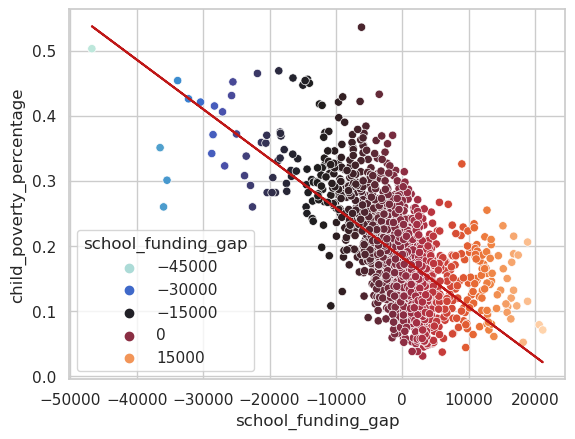

In [28]:
poly_reg_line(X_1, y_1, slope_1, intercept_1)

#### Firearm Fatalities 

In [29]:
model_2= smf.ols(formula='firearm_fatalities ~ school_funding_gap', data=agg_select_subset).fit()
intercept_2 = model_2.params.Intercept
slope_2 = model_2.params.school_funding_gap

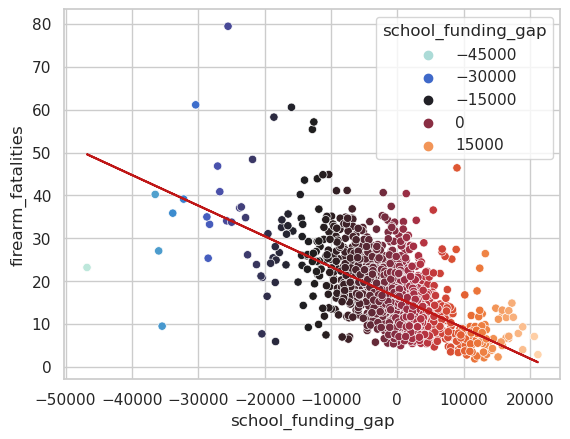

In [30]:
poly_reg_line(X_1, y_2, slope_2, intercept_2)

In [31]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     firearm_fatalities   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     945.9
Date:                Tue, 13 May 2025   Prob (F-statistic):          1.70e-164
Time:                        11:53:09   Log-Likelihood:                -5305.7
No. Observations:                1648   AIC:                         1.062e+04
Df Residuals:                    1646   BIC:                         1.063e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.1915      0.150    107.682      0.000      15.897      16.486
school_funding_gap    -0.0007   2.32e-05    -30.755      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      434.019   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2445.510
Skew:                           1.111   Prob(JB):                         0.00
Kurtosis:                       8.539   Cond. No.                     6.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Life Expectency- try polyfit

In [32]:
model_3= smf.ols(formula='life_expectancy ~ school_funding_gap', data=agg_select_subset).fit()
intercept_3 = model_3.params.Intercept
slope_3 = model_3.params.school_funding_gap

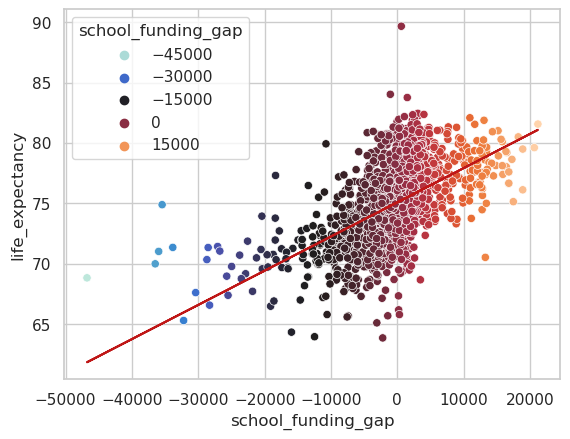

In [33]:
poly_reg_line(X_1, y_4, slope_3, intercept_3)

In [34]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     770.7
Date:                Tue, 13 May 2025   Prob (F-statistic):          1.86e-139
Time:                        11:53:37   Log-Likelihood:                -3951.1
No. Observations:                1648   AIC:                             7906.
Df Residuals:                    1646   BIC:                             7917.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             75.0806      0.066   1135.971      0.000      74.951      75.210
school_funding_gap     0.0003   1.02e-05     27.762      0.000       0.000       0.000
==============================================================================
Omnibus:                       32.940   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.169
Skew:                           0.164   Prob(JB):                     1.73e-12
Kurtosis:                       3.825   Cond. No.                     6.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Plotting Income Inequality 

In [35]:
model_4= smf.ols(formula='life_expectancy ~ income_inequality', data=agg_select_subset).fit()
intercept_4 = model_4.params.Intercept
slope_4 = model_4.params.income_inequality

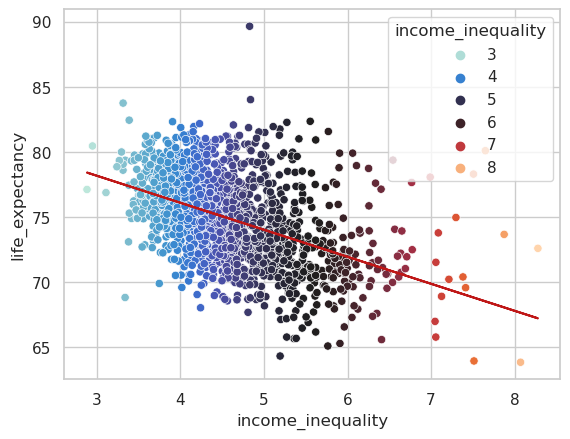

In [36]:
poly_reg_line(X_2, y_4, slope_4, intercept_4)

In [37]:
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     438.3
Date:                Tue, 13 May 2025   Prob (F-statistic):           1.77e-86
Time:                        11:53:52   Log-Likelihood:                -4073.1
No. Observations:                1648   AIC:                             8150.
Df Residuals:                    1646   BIC:                             8161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            84.4045      0.462    182.818      0.000      83.499      85.310
income_inequality    -2.0759      0.099    -20.936      0.000      -2.270      -1.881
==============================================================================
Omnibus:                       61.467   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.640
Skew:                           0.392   Prob(JB):                     5.09e-18
Kurtosis:                       3.738   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Child Poverty

In [38]:
model_5= smf.ols(formula='child_poverty_percentage ~ income_inequality', data=agg_select_subset).fit()
intercept_5 = model_5.params.Intercept
slope_5 = model_5.params.income_inequality

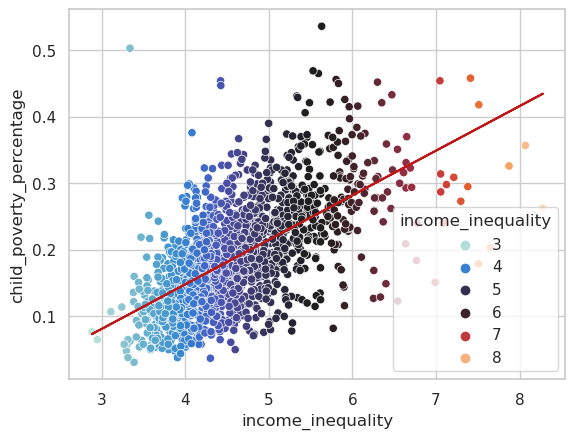

In [39]:
poly_reg_line(X_2, y_1, slope_5, intercept_5)

In [40]:
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     child_poverty_percentage   R-squared:                       0.388
Model:                                  OLS   Adj. R-squared:                  0.387
Method:                       Least Squares   F-statistic:                     1042.
Date:                      Tue, 13 May 2025   Prob (F-statistic):          1.63e-177
Time:                              11:54:12   Log-Likelihood:                 2299.8
No. Observations:                      1648   AIC:                            -4596.
Df Residuals:                          1646   BIC:                            -4585.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1197      0.010    -12.393      0.000      -0.139      -0.101
income_inequality     0.0670      0.002     32.279      0.000       0.063       0.071
==============================================================================
Omnibus:                      176.199   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.080
Skew:                           0.585   Prob(JB):                    3.76e-102
Kurtosis:                       5.331   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Median Income

In [41]:
model_6= smf.ols(formula='median_income ~ income_inequality', data=agg_select_subset).fit()
intercept_6 = model_6.params.Intercept
slope_6 = model_6.params.income_inequality

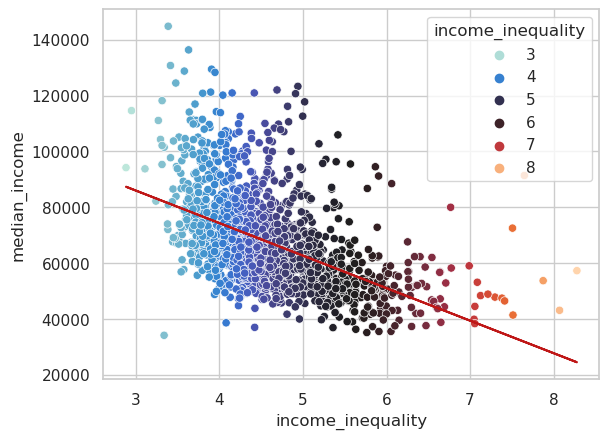

In [42]:
poly_reg_line(X_2, y_3, slope_6, intercept_6)

In [43]:
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          median_income   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     557.6
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.08e-106
Time:                        11:54:25   Log-Likelihood:                -18100.
No. Observations:                1648   AIC:                         3.620e+04
Df Residuals:                    1646   BIC:                         3.622e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.209e+05   2295.998     52.664      0.000    1.16e+05    1.25e+05
income_inequality -1.164e+04    493.112    -23.613      0.000   -1.26e+04   -1.07e+04
==============================================================================
Omnibus:                      328.592   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              638.391
Skew:                           1.184   Prob(JB):                    2.37e-139
Kurtosis:                       4.922   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multi-target- MultiRegressor

Since school funding seems to be a stronger predictor given both pairwise mutual informaiton and correlation, this multi-target method will be limited to school funding as predictor and 3 variables with the strongest correlations: 'child_poverty_percentage', 'firearm_fatalities', 'premature_death'

In [44]:
x_s = agg_select_subset[['school_funding_gap']]
y_s = agg_select_subset[['child_poverty_percentage', 'firearm_fatalities', 'premature_death']]

In [45]:
X, y = x_s, y_s
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [46]:
# Create and train the multi-target regression model (ElasticNet)
multioutput_model = MultiOutputRegressor(
    ElasticNet(alpha=0.5, l1_ratio=0.5), n_jobs=5)
multioutput_model.fit(X_train, y_train)

# Create and train the decision tree regressor model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Create and train the random forest regressor model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [47]:
# Make predictions
multioutput_pred = multioutput_model.predict(X_test)
tree_pred = tree_model.predict(X_test)
forest_pred = forest_model.predict(X_test)
 
# Calculate performance metrics for multioutput model
multioutput_mse = mean_squared_error(y_test, multioutput_pred)
multioutput_mae = mean_absolute_error(y_test, multioutput_pred)
 
# Calculate performance metrics for decision tree model
tree_mse = mean_squared_error(y_test, tree_pred)
tree_mae = mean_absolute_error(y_test, tree_pred)

# Calculate performance metrics for random forest model
forest_mse = mean_squared_error(y_test, forest_pred)
forest_mae = mean_absolute_error(y_test, forest_pred)

# Print the performance metrics
print("Multioutput Model - Mean Squared Error:", multioutput_mse)
print("Multioutput Model - Mean Absolute Error:", multioutput_mae)
print("Decision Tree Model - Mean Squared Error:", tree_mse)
print("Decision Tree Model - Mean Absolute Error:", tree_mae)
print("Random Forest Model - Mean Squared Error:", forest_mse)
print("Random Forest Model - Mean Absolute Error:", forest_mae)

Multioutput Model - Mean Squared Error: 2564566.4458838087
Multioutput Model - Mean Absolute Error: 688.395513007291
Decision Tree Model - Mean Squared Error: 4817744.602264917
Decision Tree Model - Mean Absolute Error: 978.7717797979803
Random Forest Model - Mean Squared Error: 3341823.774260262
Random Forest Model - Mean Absolute Error: 819.3617219494948


### MSE/MAE Comparative Visualization

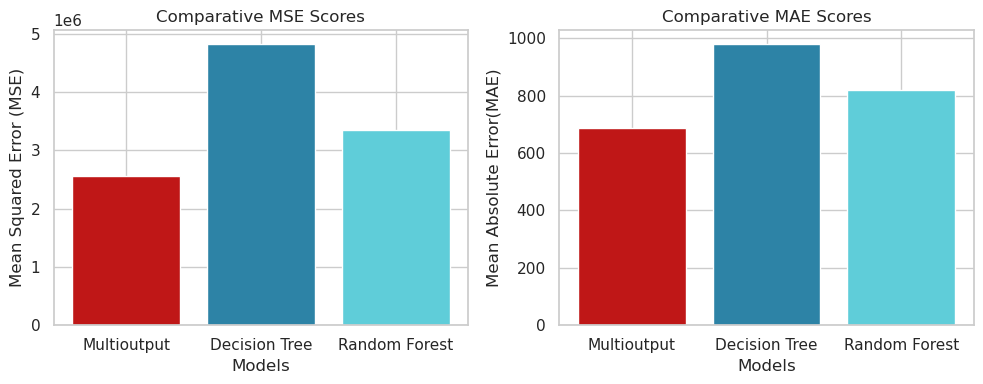

In [48]:
# Create a comparative visualization
plt.figure(figsize=(10, 4))
models = ['Multioutput', 'Decision Tree', 'Random Forest']
mse_scores = [multioutput_mse, tree_mse, forest_mse]
mae_scores = [multioutput_mae, tree_mae, forest_mae]
 
# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 1)
plt.bar(models, mse_scores, color=['#BF1717', '#2D83A6', '#5FCDD9'])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparative MSE Scores')

# Plot R-squared Score (R2)
plt.subplot(1, 2, 2)
plt.bar(models, mae_scores, color=['#BF1717', '#2D83A6', '#5FCDD9'])
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error(MAE)')
plt.title('Comparative MAE Scores')

plt.tight_layout()
plt.show()

Multiouput model performed bets out of the 3 compared

## Polynomial

#### Scool-Funding vs. Child Poverty

In [49]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

In [50]:
poly_features = poly.fit_transform(X_1.values.reshape(-1, 1))
# Create a polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_1)
# Make predictions  
y_predicted = poly_reg_model.predict(poly_features)

In [52]:
r_sq_poly = poly_reg_model.score(poly_features, y_1)
print(f'R_squared: {r_sq_poly}')
print(f'intercept: {poly_reg_model.intercept_}')
print(f'slope: {poly_reg_model.coef_}')

R_squared: 0.4114974510580618
intercept: 0.18040801095623343
slope: [-7.14102916e-06  5.35084088e-11]


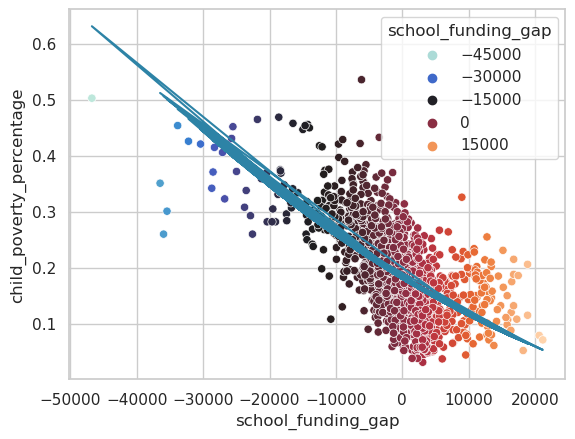

In [53]:
sns.scatterplot(x = X_1, y = y_1, hue = X_1, palette ='icefire') 
plt.plot(X_1, y_predicted, color=line_color_1)

### Income Inequality Median Income 

In [55]:
poly_features_2 = poly.fit_transform(X_2.values.reshape(-1, 1))
# Create a polynomial regression model
poly_reg_model_2 = LinearRegression()
poly_reg_model_2.fit(poly_features_2, y_3)
# Make predictions  
y_predicted_2 = poly_reg_model_2.predict(poly_features_2)

In [56]:
r_sq = poly_reg_model_2.score(poly_features_2, y_3)
print(f'R_squared: {r_sq}')
print(f'intercept: {poly_reg_model_2.intercept_}')
print(f'slope: {poly_reg_model_2.coef_}')

R_squared: 0.286064616329609
intercept: 206454.41175449148
slope: [-46911.21222769   3539.65453973]


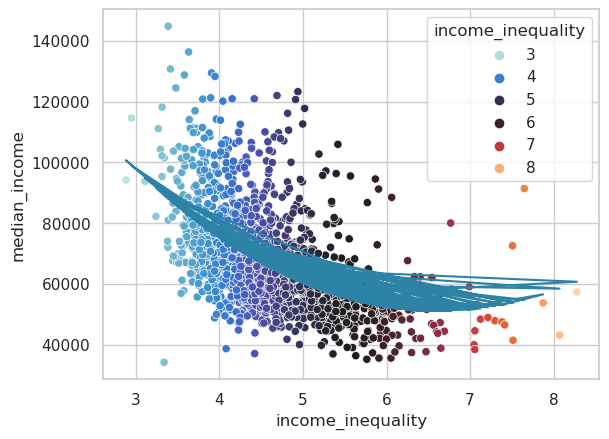

In [57]:
sns.scatterplot(x = X_2, y = y_3, hue = X_2, palette ='icefire') 
plt.plot(X_2, y_predicted_2, color=line_color_1)

# Group Observations

## Defining Groups

In [58]:
grouped_df = agg_select_subset.copy()
# adding column with inequality quantile 
grouped_df['quartile_income_inequality'] = pd.qcut(grouped_df['income_inequality'], q=4, labels=False)
# adding column defining whether county meets federal school funding requirements
grouped_df['meeting_school_funding_requirement'] = np.where(grouped_df['school_funding_gap']>=0, 'yes', 'no')
school_funding_grouped = grouped_df.groupby('meeting_school_funding_requirement')
income_inequality_grouped = grouped_df.groupby('quartile_income_inequality')

### Descriptive Stats Accross Groups

In [60]:
school_funding_grouped.describe().round(2)

school_funding_gap                    \
                                                count     mean      std   
meeting_school_funding_requirement                                        
no                                              875.0 -4815.79  5483.21   
yes                                             773.0  3735.09  3906.57   

                                                                        \
                                         min      25%      50%     75%   
meeting_school_funding_requirement                                       
no                                 -46776.99 -6134.39 -3126.54 -1410.7   
yes                                     1.63  1182.52  2472.09  4430.5   

                                             child_poverty_percentage        \
                                         max                    count  mean   
meeting_school_funding_requirement                                            
no                                     -0.25                    875.0  0.23   
yes                                 21187.84                    773.0  0.15   

                                    ... premature_death            \
                                    ...             75%       max   
meeting_school_funding_requirement  ...                             
no                                  ...        13711.18  27851.41   
yes                                 ...        10292.25  22436.81   

                                   quartile_income_inequality              \
                                                        count  mean   std   
meeting_school_funding_requirement                                          
no                                                      875.0  1.80  1.09   
yes                                                     773.0  1.15  1.05   

                                                             
                                    min  25%  50%  75%  max  
meeting_school_funding_requirement                           
no                                  0.0  1.0  2.0  3.0  3.0  
yes                                 0.0  0.0  1.0  2.0  3.0  

[2 rows x 64 columns]

In [61]:
income_inequality_grouped.describe().round(2)

school_funding_gap                              \
                                        count     mean      std       min   
quartile_income_inequality                                                  
0                                       415.0  1283.16  4454.76 -46776.99   
1                                       410.0   343.50  5061.11 -33847.18   
2                                       411.0  -253.23  5797.63 -23516.77   
3                                       412.0 -4601.62  8132.18 -36495.30   

                                                                 \
                                25%      50%      75%       max   
quartile_income_inequality                                        
0                           -797.90  1261.39  3061.95  18231.33   
1                          -2316.61   134.71  2460.44  21187.84   
2                          -3365.77  -524.42  2039.25  18898.09   
3                          -7886.41 -3698.88    20.30  18897.74   

                           child_poverty_percentage        ...  \
                                              count  mean  ...   
quartile_income_inequality                                 ...   
0                                             415.0  0.13  ...   
1                                             410.0  0.17  ...   
2                                             411.0  0.20  ...   
3                                             412.0  0.26  ...   

                           life_expectancy        premature_death            \
                                       75%    max           count      mean   
quartile_income_inequality                                                    
0                                    78.55  83.76           415.0   8403.42   
1                                    76.99  82.18           410.0   9797.68   
2                                    76.38  89.67           411.0  10886.34   
3                                    74.49  82.36           412.0  12855.18   

                                                                            \
                                std      min       25%       50%       75%   
quartile_income_inequality                                                   
0                           2268.09  3990.29   6864.09   8307.46   9670.95   
1                           2386.14  4276.04   8195.96   9699.57  11381.38   
2                           2833.99  4321.36   8889.13  10984.49  12661.47   
3                           3813.64  4157.99  10408.09  12912.68  14843.19   

                                      
                                 max  
quartile_income_inequality            
0                           19407.34  
1                           18377.17  
2                           18735.53  
3                           27851.41  

[4 rows x 56 columns]

## Group Pair Plots

In [1]:
group_palette = {'yes': '#2D83A6', 'no': '#401616', 1:'#2D83A6' , 0: '#5FCDD9', 2: '#BF1717',  3: '#401616'}

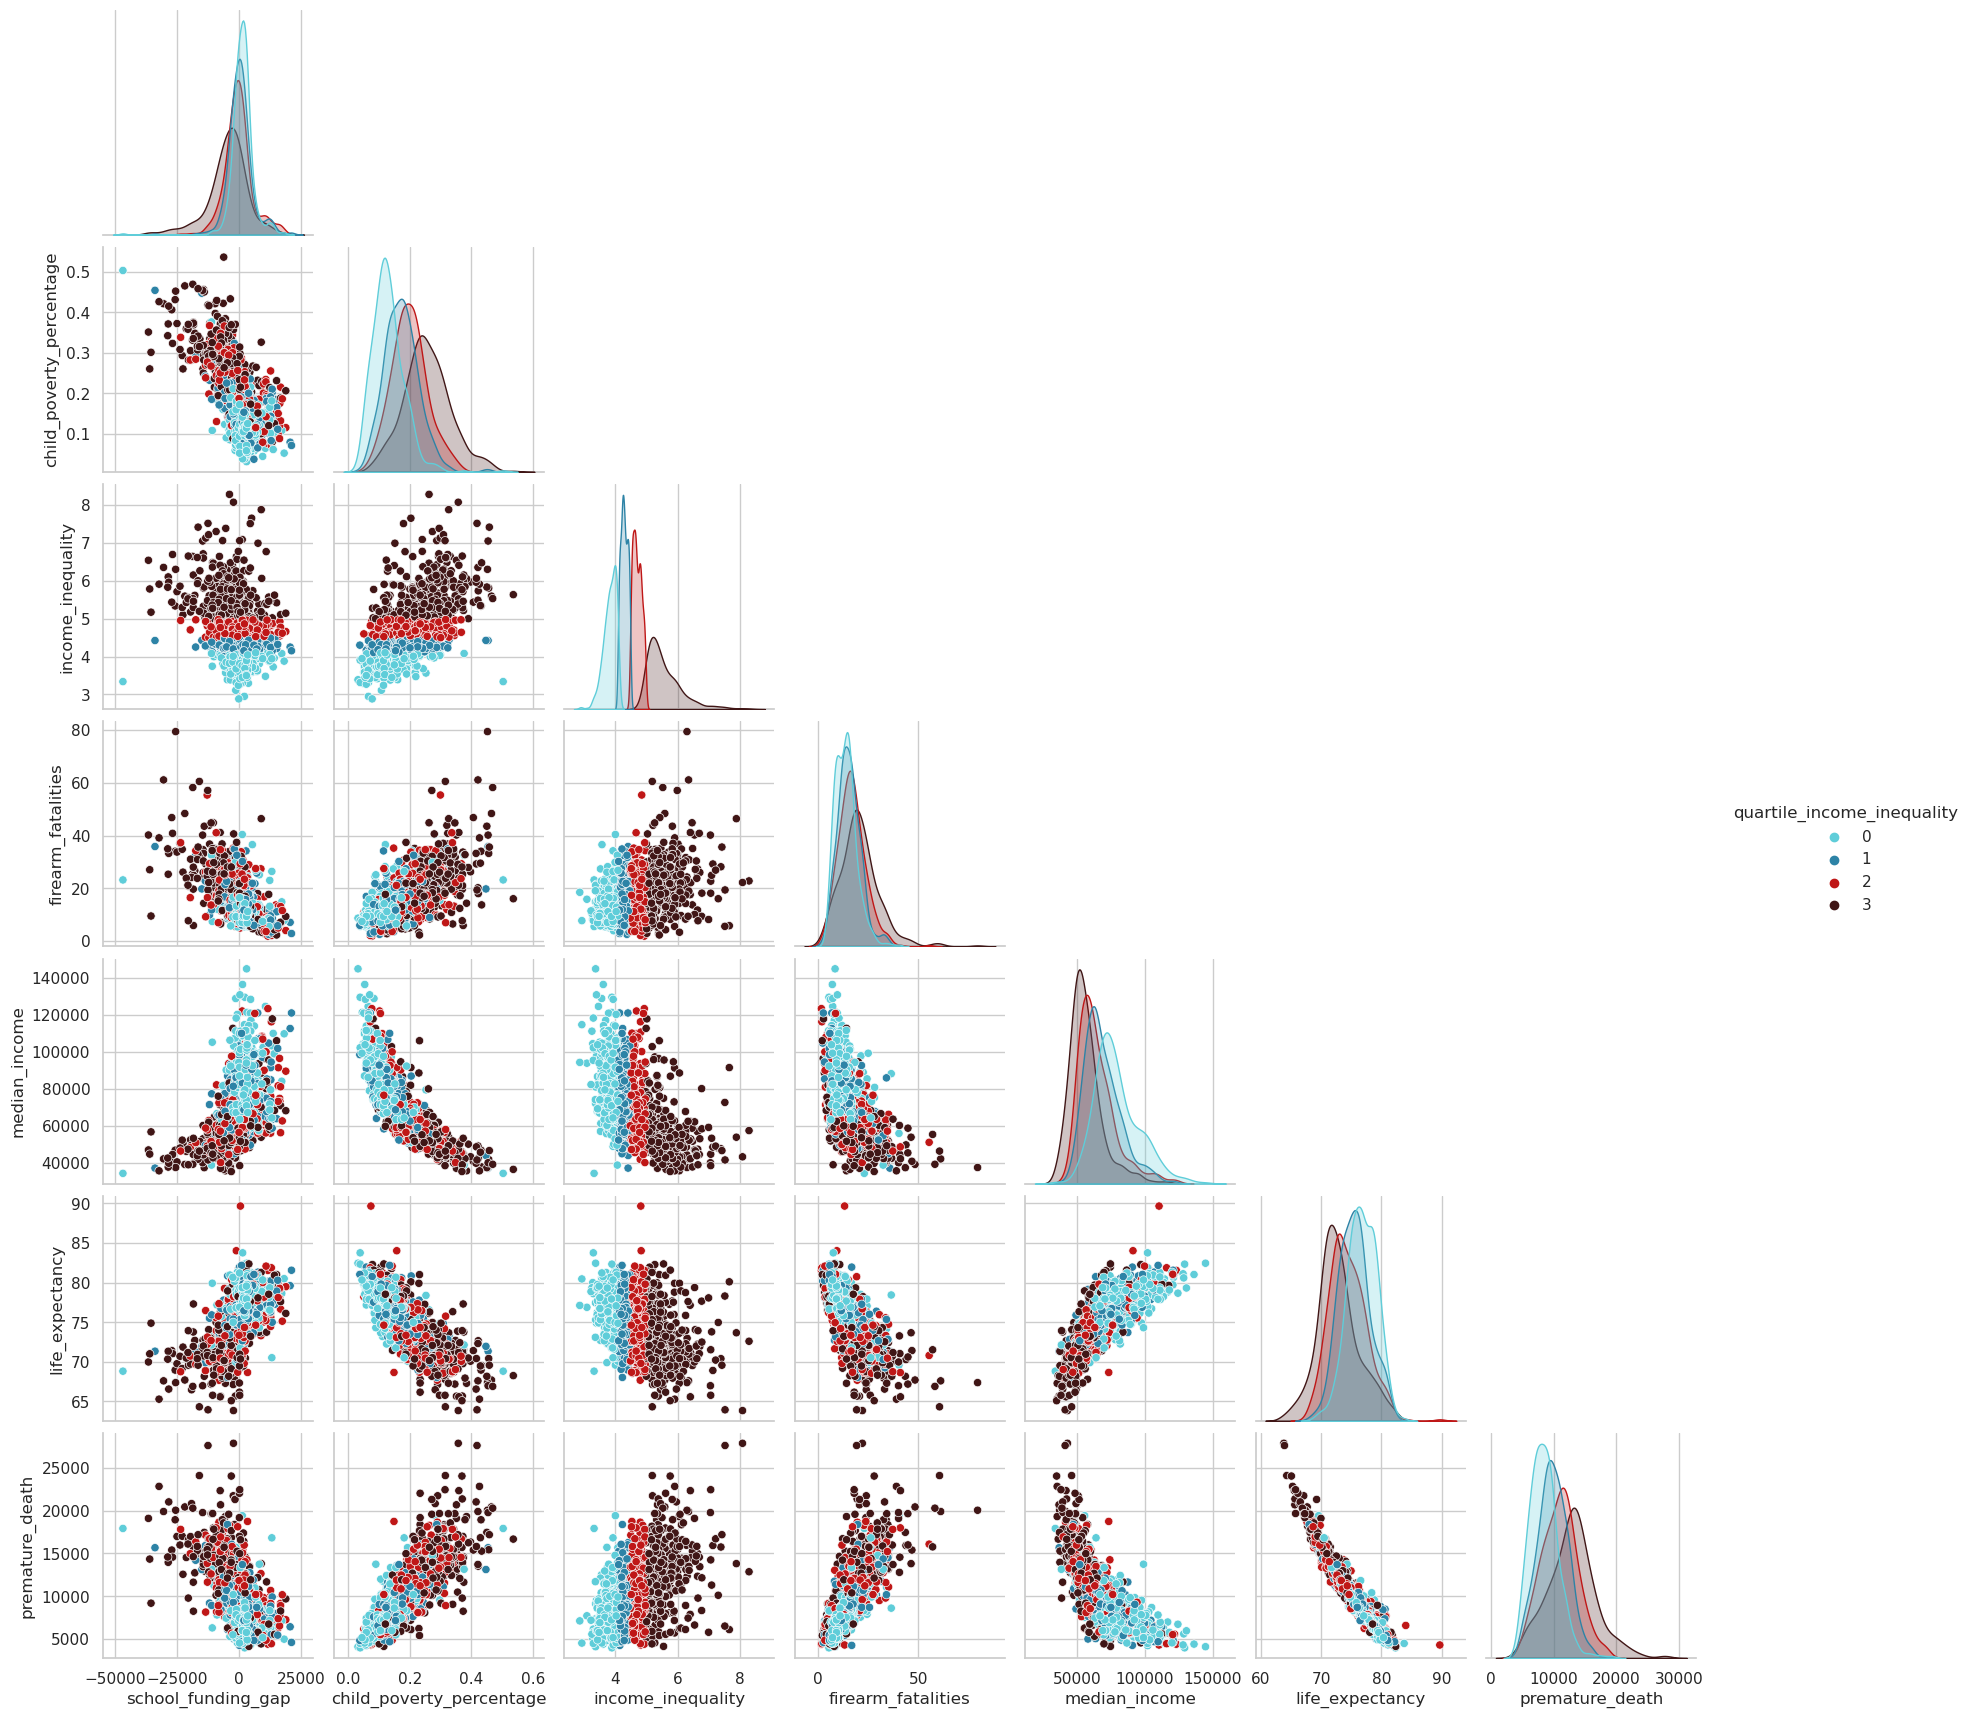

In [59]:
sns.pairplot(grouped_df, hue='quartile_income_inequality', palette=group_palette, corner=True)
plt.show()

#### Across Schools Meeting Federal School Funding Requirements per pupil and those failing to meet them 

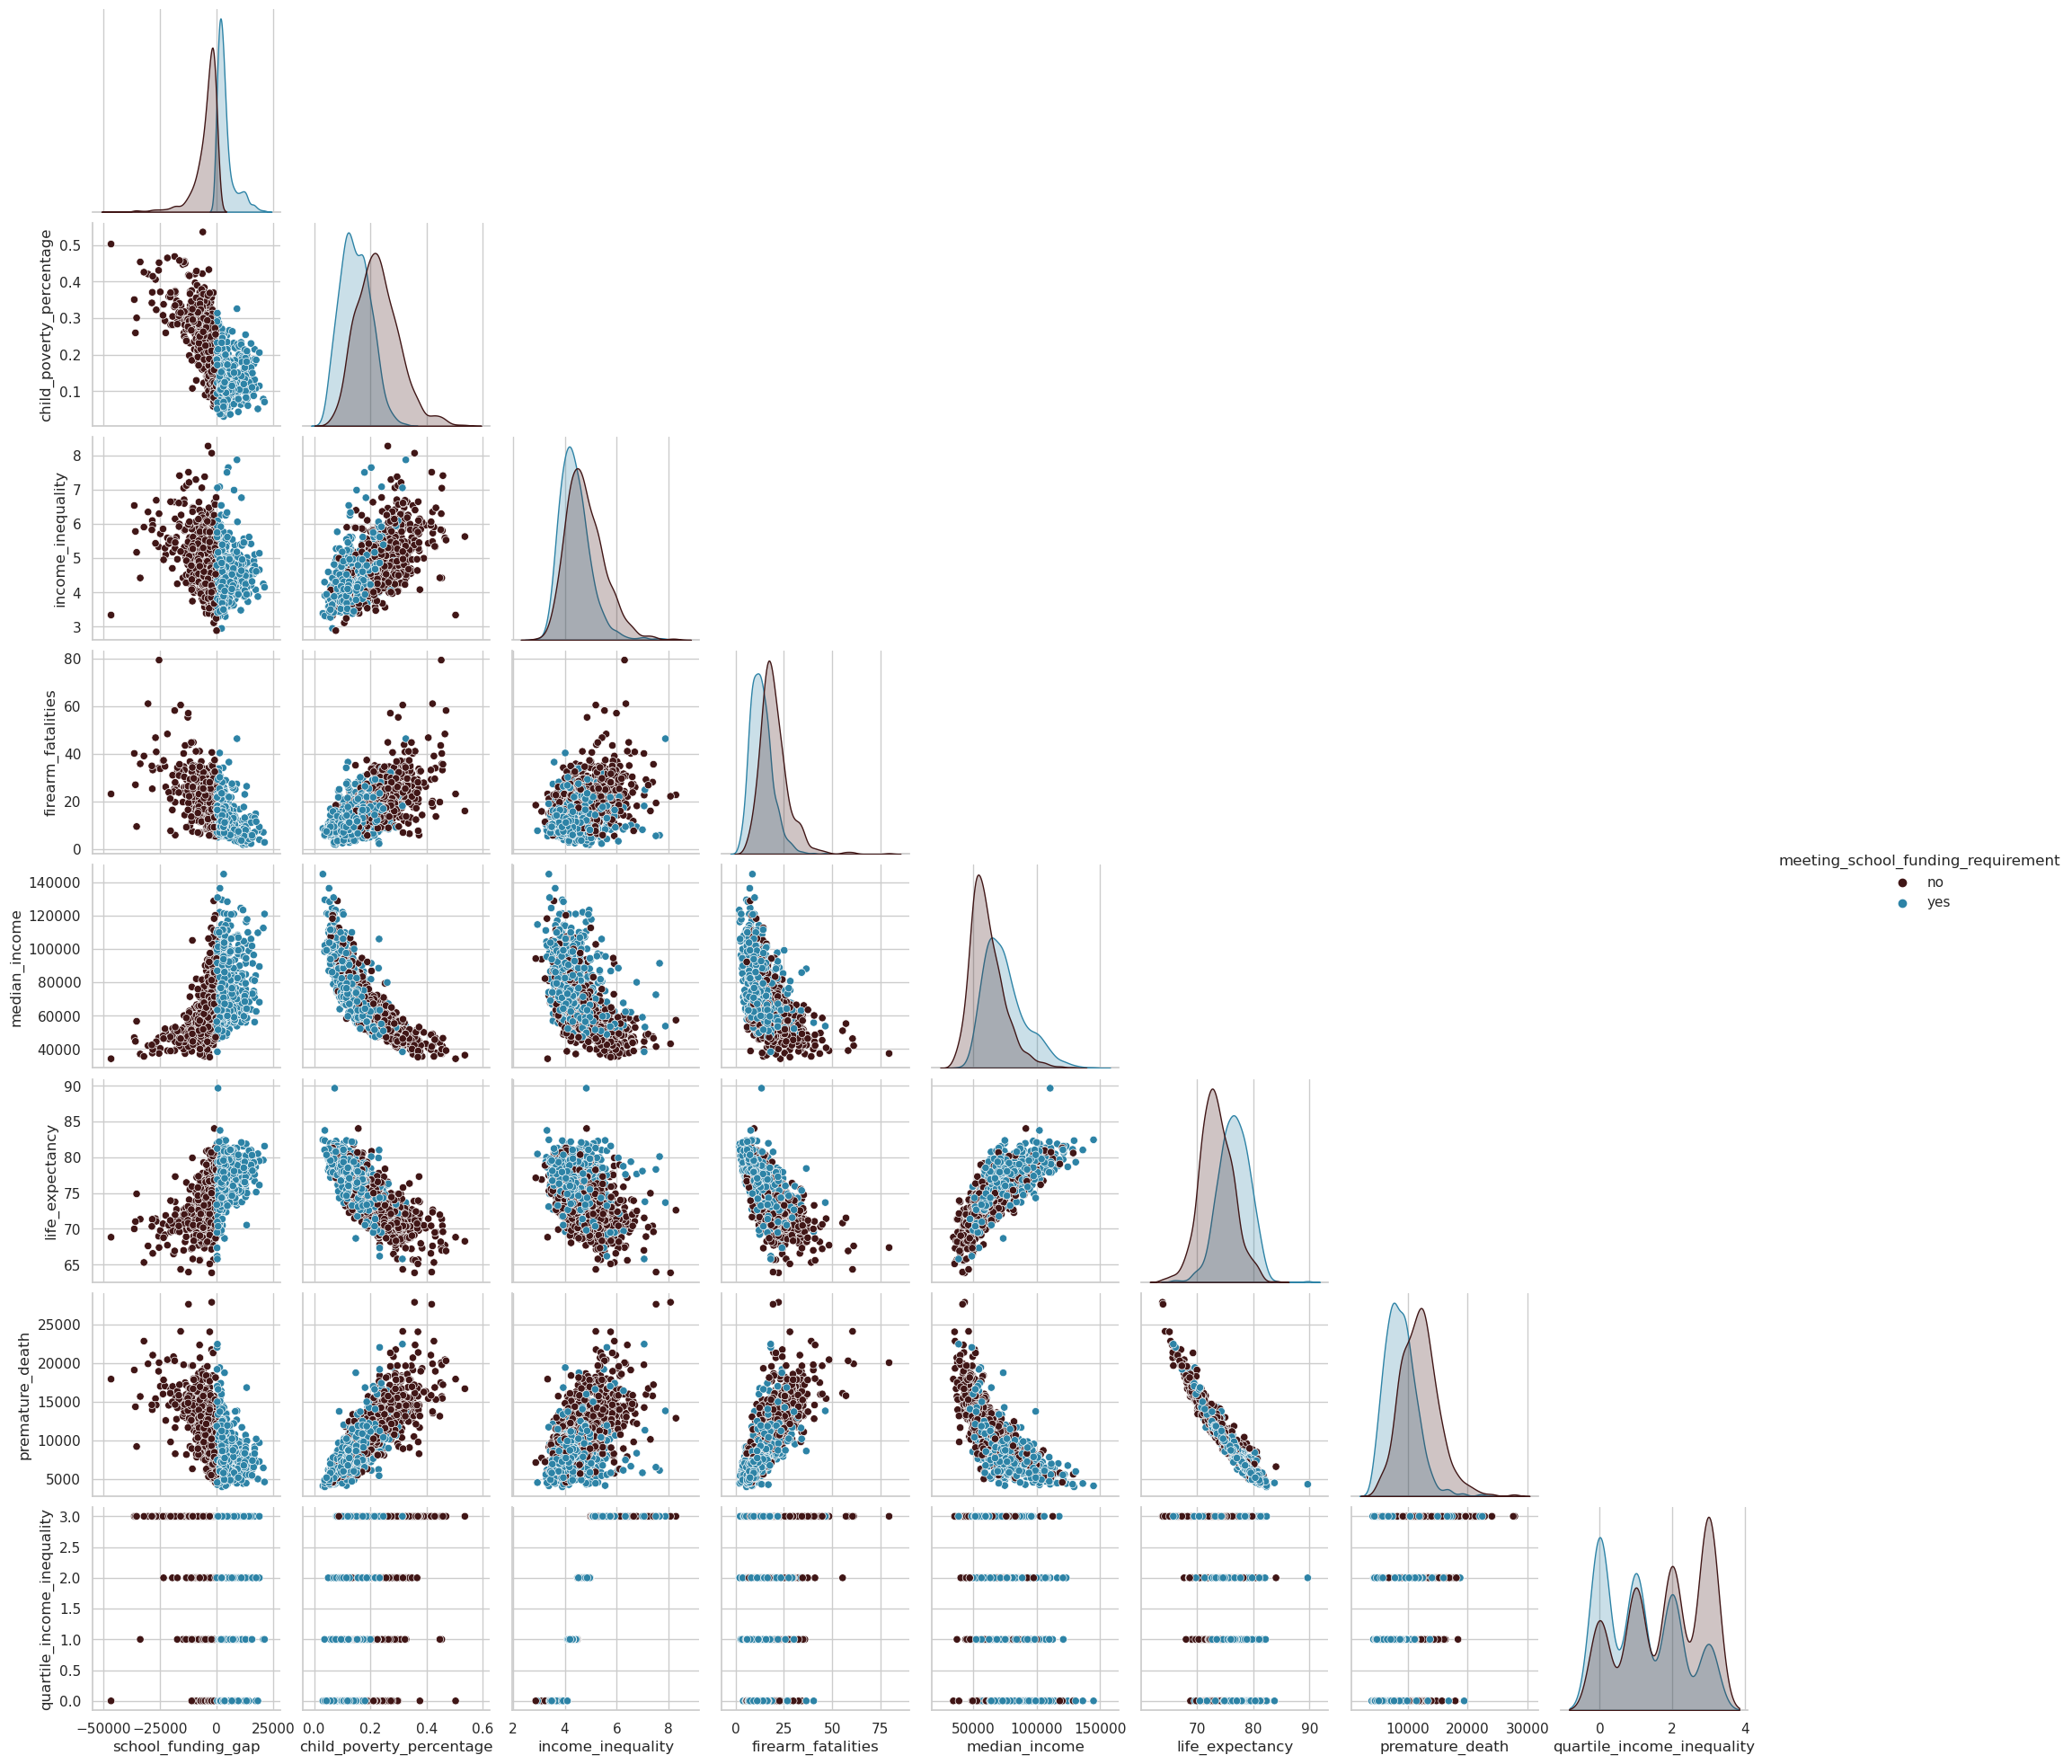

In [60]:
sns.pairplot(grouped_df, hue='meeting_school_funding_requirement', palette=group_palette, corner=True)
plt.show()

# Statistical Testing- Differences accross groups

## Comparing Means

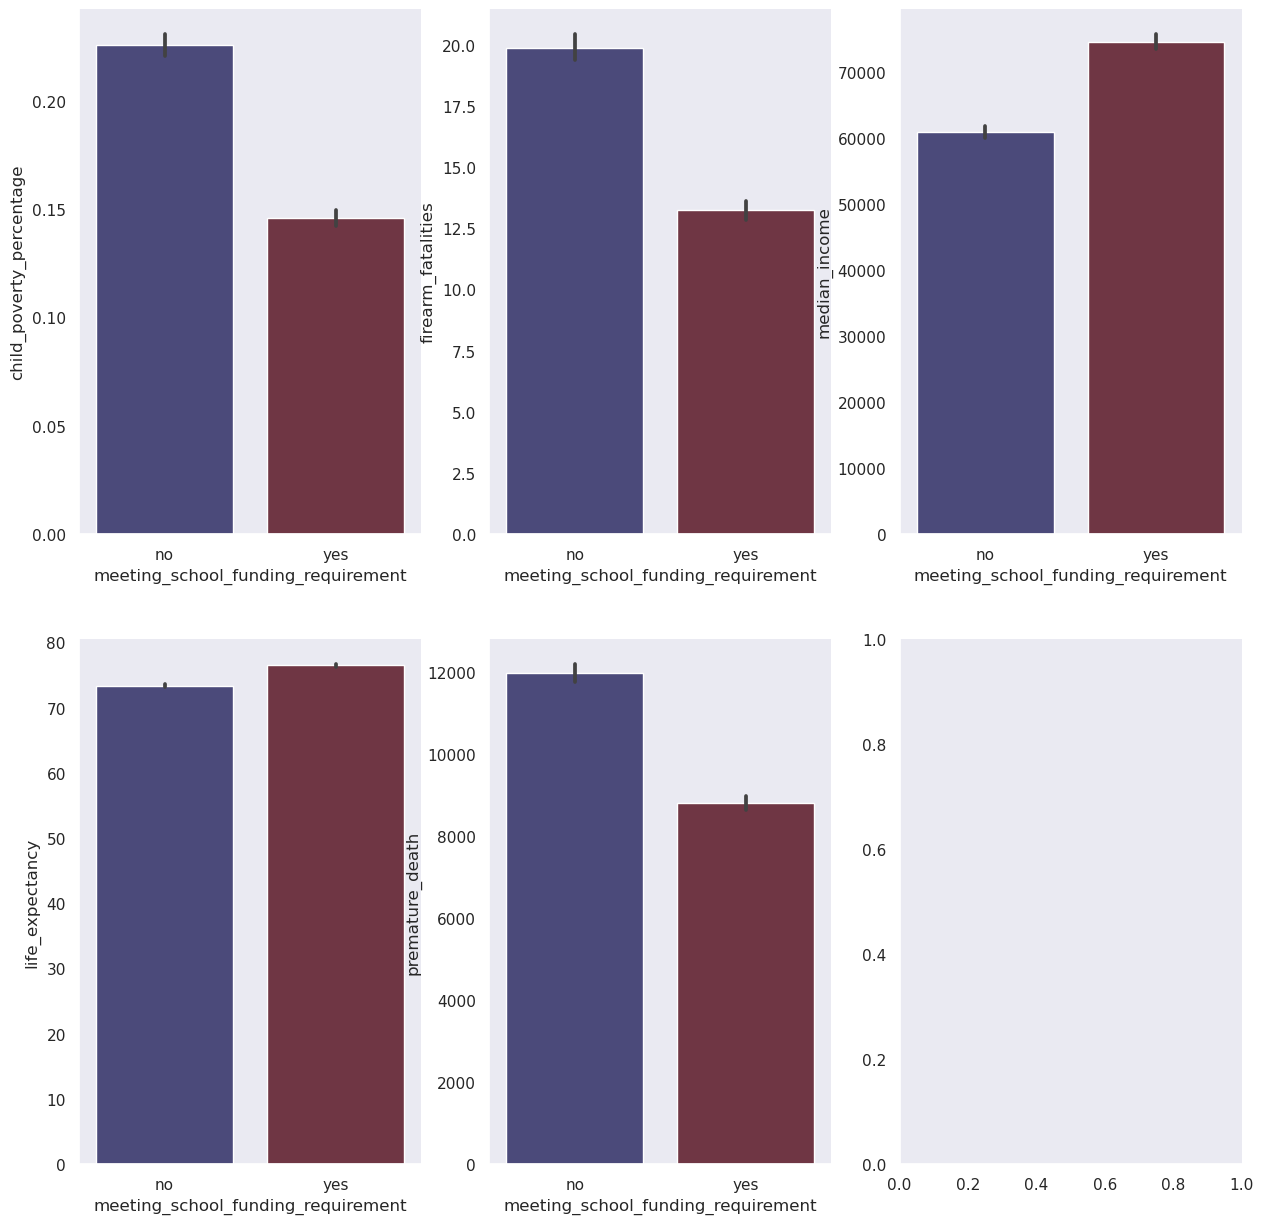

In [131]:
#sns.set(style='dark')
fig, axes = plt.subplots(2,3, figsize=(15, 15))
palette=sns.color_palette('icefire', 2)
sns.barplot(x='meeting_school_funding_requirement', y = 'child_poverty_percentage', data = grouped_df, ax=axes[0,0], palette=palette) 
sns.barplot(x='meeting_school_funding_requirement', y = 'firearm_fatalities', data = grouped_df, ax=axes[0,1], palette=palette)
sns.barplot(x='meeting_school_funding_requirement', y = 'median_income', data = grouped_df, ax=axes[0,2], palette=palette)
sns.barplot(x='meeting_school_funding_requirement', y = 'life_expectancy', data = grouped_df, ax=axes[1,0], palette=palette)
sns.barplot(x='meeting_school_funding_requirement', y = 'premature_death', data = grouped_df, ax=axes[1,1], palette=palette)
sns.despine()
plt.show()

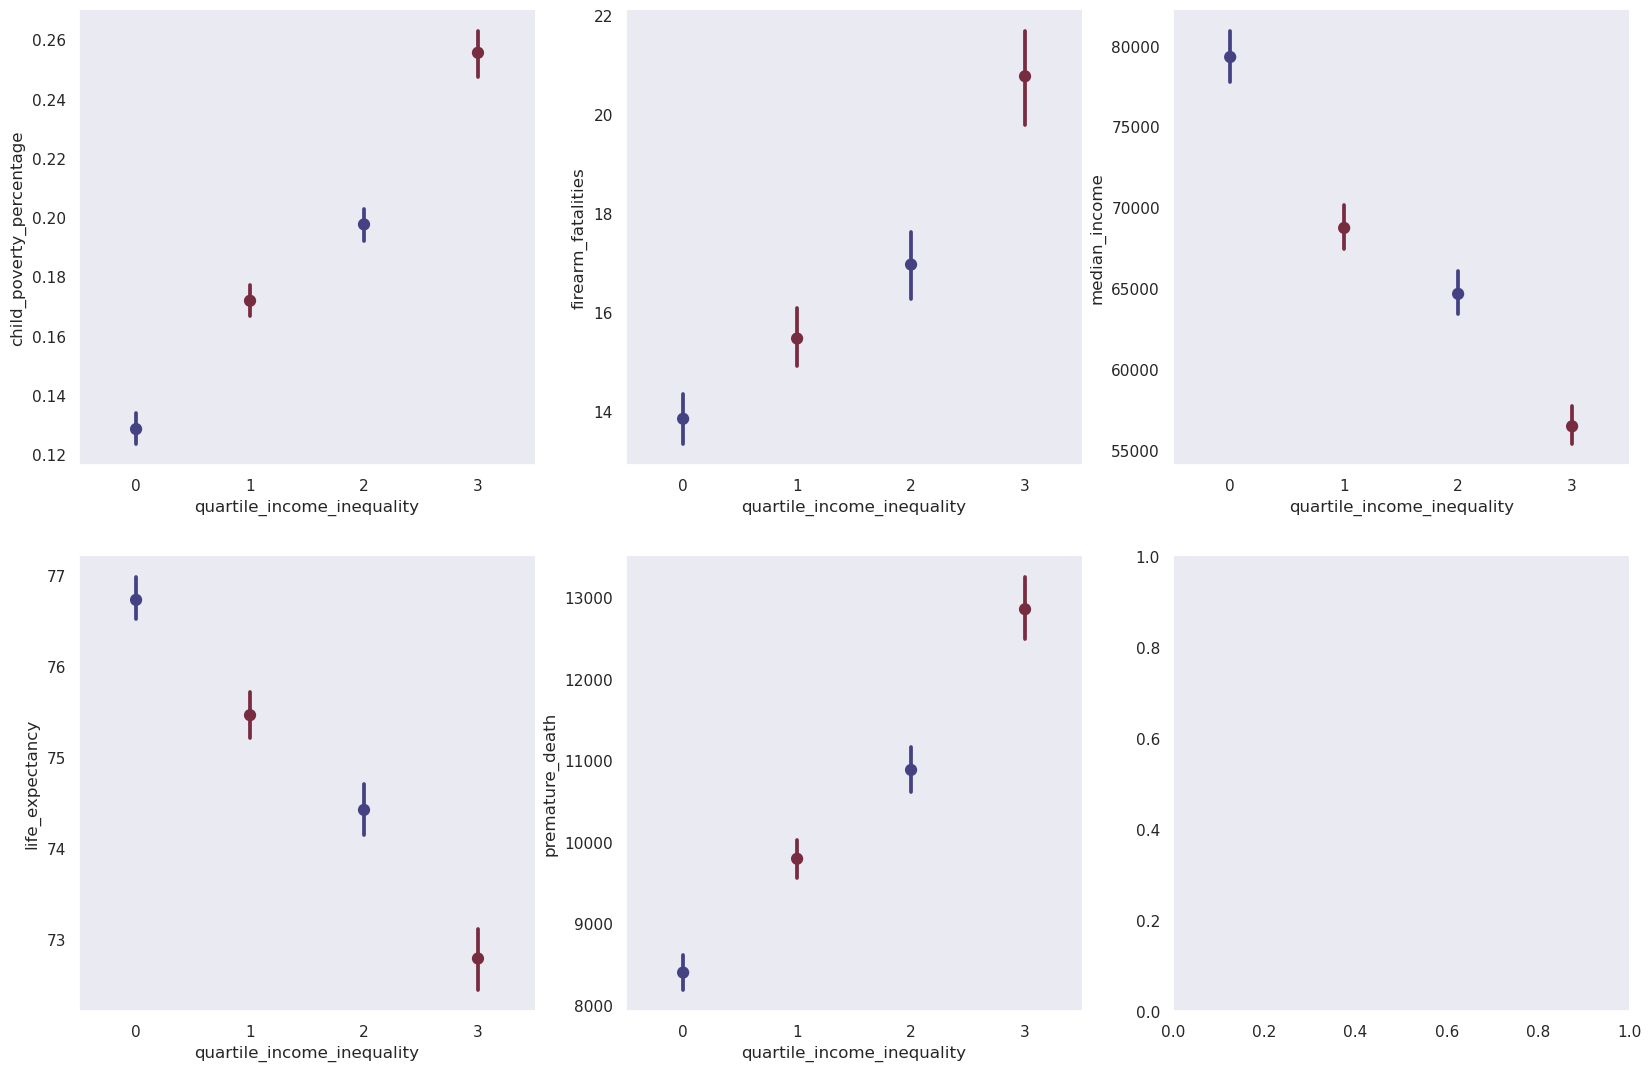

In [133]:

fig, axes = plt.subplots(2,3, figsize=(20, 13))
palette=sns.color_palette('icefire', 2)
sns.pointplot(x='quartile_income_inequality', y = 'child_poverty_percentage', data = grouped_df, ax=axes[0,0], palette=palette)
sns.pointplot(x='quartile_income_inequality', y = 'firearm_fatalities', data = grouped_df, ax=axes[0,1], palette=palette)
sns.pointplot(x='quartile_income_inequality', y = 'median_income', data = grouped_df, ax=axes[0,2], palette=palette)
sns.pointplot(x='quartile_income_inequality', y = 'life_expectancy', data = grouped_df, ax=axes[1,0], palette=palette)
sns.pointplot(x='quartile_income_inequality', y = 'premature_death', data = grouped_df, ax=axes[1,1], palette=palette)
sns.despine()
plt.show()

In [104]:
print(y_vars)

['child_poverty_percentage', 'firearm_fatalities', 'median_income', 'life_expectancy', 'premature_death']


## Hypothesis
$H_{01}$ Counties that meet school funding requirements and those that do not have no difference in mean accross selected socio-economic metrics

$H_{02}$ Counties across all for quartiles of income inequality have no difference in mean accross selected socio-economic metrics

$H_{A1}$ There is a difference in mean between counties that meet school funding requirements and those that do not

$H_{A2}$ There is a difference in mean between Counties across all for quartiles of income inequality

## Chi-Squared Testing

In [61]:
from scipy.stats import chi2_contingency
# Defining a function to perform the Chi-Square Test and interpret results
def perform_chi_square_test(data, col1, col2):
    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant

# Additional aspects to test 
additional_aspects_to_test = {
    'Whether School meets required federal funding and child poverty': ('meeting_school_funding_requirement', 'child_poverty_percentage'),
    'Whether School meets required federal funding and firearm fatalities': ('meeting_school_funding_requirement', 'firearm_fatalities'),
    'Whether School meets required federal funding and life expectancy': ('meeting_school_funding_requirement', 'life_expectancy'),
    'Whether School meets required federal funding and median income': ('meeting_school_funding_requirement', 'median_income'),
    'Whether School meets required federal funding and premature death': ('meeting_school_funding_requirement', 'premature_death'),
    'Income Inequality Quartile and child poverty': ('quartile_income_inequality', 'child_poverty_percentage'),
    'Income Inequality Quartile and firearm fatalities': ('quartile_income_inequality', 'firearm_fatalities'),
    'Income Inequality Quartile and life expectancy': ('quartile_income_inequality', 'life_expectancy'),
    'Income Inequality Quartile and median income': ('quartile_income_inequality', 'median_income'),
    'Income Inequality Quartile and premature death': ('quartile_income_inequality', 'premature_death'),
    'Political Party and child poverty': ('political_party', 'child_poverty_percentage'),
    'Political Party and firearm fatalities': ('political_party', 'firearm_fatalities'),
    'Political Party and life expectancy': ('political_party', 'life_expectancy'),
    'Political Party and median income': ('political_party', 'median_income'),
    'Political Party and premature death': ('political_party', 'premature_death'),
}


In [84]:
additional_mat_chi_square_results = {aspect: perform_chi_square_test(grouped_df, *columns) for aspect, columns in additional_aspects_to_test.items()}
additional_mat_chi_square_results

{'Whether School meets required federal funding and child poverty': (np.float64(653.4111500985841),
  np.float64(1.2842473003621774e-22),
  np.True_),
 'Whether School meets required federal funding and firearm fatalities': (np.float64(1589.1077306720877),
  np.float64(0.4451122833120476),
  np.False_),
 'Whether School meets required federal funding and life expectancy': (np.float64(1581.076966672827),
  np.float64(0.31669809901063806),
  np.False_),
 'Whether School meets required federal funding and median income': (np.float64(1621.2307866691308),
  np.float64(0.47970268362438123),
  np.False_),
 'Whether School meets required federal funding and premature death': (np.float64(1648.0),
  np.float64(0.48841810656984014),
  np.False_),
 'Income Inequality Quartile and child poverty': (np.float64(1538.0970210044675),
  np.float64(8.140812283636531e-25),
  np.True_),
 'Income Inequality Quartile and firearm fatalities': (np.float64(4754.5868023992),
  np.float64(0.4621873864586245),
  np

In [63]:
grouped_df.groupby('meeting_school_funding_requirement').mean(numeric_only=True).round(2)

school_funding_gap  \
meeting_school_funding_requirement                       
no                                            -4815.79   
yes                                            3735.09   

                                    child_poverty_percentage  \
meeting_school_funding_requirement                             
no                                                      0.23   
yes                                                     0.15   

                                    income_inequality  firearm_fatalities  \
meeting_school_funding_requirement                                          
no                                               4.79               19.88   
yes                                              4.39               13.24   

                                    median_income  life_expectancy  \
meeting_school_funding_requirement                                   
no                                       60897.16            73.39   
yes                                      74628.61            76.50   

                                    premature_death  \
meeting_school_funding_requirement                    
no                                         11972.43   
yes                                         8795.87   

                                    quartile_income_inequality  
meeting_school_funding_requirement                              
no                                                        1.80  
yes                                                       1.15

In [64]:
grouped_df.groupby('quartile_income_inequality').mean(numeric_only=True).round(2)

school_funding_gap  child_poverty_percentage  \
quartile_income_inequality                                                 
0                                      1283.16                      0.13   
1                                       343.50                      0.17   
2                                      -253.23                      0.20   
3                                     -4601.62                      0.26   

                            income_inequality  firearm_fatalities  \
quartile_income_inequality                                          
0                                        3.83               13.86   
1                                        4.29               15.48   
2                                        4.71               16.97   
3                                        5.57               20.77   

                            median_income  life_expectancy  premature_death  
quartile_income_inequality                                                   
0                                79320.61            76.73          8403.42  
1                                68757.31            75.46          9797.68  
2                                64685.21            74.42         10886.34  
3                                56501.83            72.79         12855.18

In [65]:
school_funding_table = grouped_df.groupby('meeting_school_funding_requirement').mean(numeric_only=True).round(3)

# MANOVA

## School Funding Only 

In [66]:
from statsmodels.multivariate.manova import MANOVA

In [74]:
grouped_df['meeting_school_funding_requirement'] = grouped_df['meeting_school_funding_requirement'].astype('category')
grouped_df['quartile_income_inequality'] = grouped_df['quartile_income_inequality'].astype('category')

In [75]:
fit = MANOVA.from_formula('child_poverty_percentage + firearm_fatalities + premature_death ~ meeting_school_funding_requirement', data=grouped_df)
print(fit.mv_test())

                         Multivariate linear model
                                                                           
-----------------------------------------------------------------------------
          Intercept          Value    Num DF     Den DF     F Value    Pr > F
-----------------------------------------------------------------------------
             Wilks' lambda   0.0981   3.0000   1644.0000   5035.3889   0.0000
            Pillai's trace   0.9019   3.0000   1644.0000   5035.3889   0.0000
    Hotelling-Lawley trace   9.1887   3.0000   1644.0000   5035.3889   0.0000
       Roy's greatest root   9.1887   3.0000   1644.0000   5035.3889   0.0000
---------------------------------------------------------------------------
                                                                           
---------------------------------------------------------------------------
 meeting_school_funding_requirement Value  Num DF   Den DF  F Value  Pr > F
-----------------------

## Income Inequality Only

In [76]:
fit = MANOVA.from_formula('child_poverty_percentage + life_expectancy + median_income ~ quartile_income_inequality', data=grouped_df)
print(fit.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept         Value   Num DF   Den DF    F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda   0.0023 3.0000 1642.0000 240222.9783 0.0000
         Pillai's trace   0.9977 3.0000 1642.0000 240222.9783 0.0000
 Hotelling-Lawley trace 438.8970 3.0000 1642.0000 240222.9783 0.0000
    Roy's greatest root 438.8970 3.0000 1642.0000 240222.9783 0.0000
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
  quartile_income_inequality Value  Num DF   Den DF  F Value  Pr > F
--------------------------------------------------------------------
               Wilks' lambda 0.6225 9.0000 3996.3471  95

## All Variables

In [100]:
fit = MANOVA.from_formula('child_poverty_percentage + life_expectancy + median_income ~ quartile_income_inequality + meeting_school_funding_requirement', data=grouped_df)
print(fit.mv_test())

                         Multivariate linear model
                                                                           
----------------------------------------------------------------------------
          Intercept          Value    Num DF    Den DF     F Value    Pr > F
----------------------------------------------------------------------------
             Wilks' lambda    0.0033  3.0000  1641.0000  163776.1167  0.0000
            Pillai's trace    0.9967  3.0000  1641.0000  163776.1167  0.0000
    Hotelling-Lawley trace  299.4079  3.0000  1641.0000  163776.1167  0.0000
       Roy's greatest root  299.4079  3.0000  1641.0000  163776.1167  0.0000
---------------------------------------------------------------------------
                                                                           
----------------------------------------------------------------------------
     quartile_income_inequality  Value   Num DF    Den DF   F Value   Pr > F
----------------------------

# LDA

In [98]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
x = grouped_df[['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']]
y = grouped_df['meeting_school_funding_requirement']
post_hoc = lda().fit(X=X, y=y)

In [87]:
post_hoc.priors_

array([0.5309466, 0.4690534])

In [88]:
post_hoc.means_

array([[-4815.78869029],
       [ 3735.08519664]])

In [89]:
post_hoc.scalings_

array([[0.00020796]])

In [90]:
post_hoc.explained_variance_ratio_

array([1.])

In [97]:
post_hoc

LinearDiscriminantAnalysis()

# Conclusion

## MANOVA
1. Wilks Lamda 